In [1]:
import datetime 
import operator
import sqlite3

import numpy
import scipy.stats
import scipy.stats.mstats

import matplotlib.cm as cm
import matplotlib.patches as mpatches
import matplotlib.pyplot as plot

dbPath = "www/wsgi-scripts/carLog.db"
conn = sqlite3.connect(dbPath)

c = conn.cursor()
c.execute("select fromDate, toDate, tripMileage, totalMileage, gallons, pricePerGallon, destinationId from mileageEntries where vehicleId = 1");
results = c.fetchall()

data = []
for result in results:
    data.append({
        "fromDate": datetime.datetime.strptime(operator.itemgetter(0)(result), "%Y-%m-%d %H:%M:%S"),
        "toDate": datetime.datetime.strptime(operator.itemgetter(1)(result), "%Y-%m-%d %H:%M:%S"),
        "tripMileage": float(operator.itemgetter(2)(result)),
        "totalMileage" : float(operator.itemgetter(3)(result)),
        "gallons": float(operator.itemgetter(4)(result)),
        "pricePerGallon": float(operator.itemgetter(5)(result)),
        "destinationId" : operator.itemgetter(6)(result)
    })

c.execute("select id, name from destinations")
results = c.fetchall()
nameFromDestId = { i : name for (i, name) in results }
    
c.close()

In [2]:
fromDates = map(lambda x : x["fromDate"], data)
toDates = map(lambda x : x["toDate"], data)
tripMileage = numpy.array(map(lambda x : x["tripMileage"], data))
gallons = numpy.array(map(lambda x : x["gallons"], data))
pricePerGallon = numpy.array(map(lambda x : x["pricePerGallon"], data))
destinations = map(lambda x : x["destinationId"], data)

dateBins = xrange(min(fromDates).year, max(fromDates).year + 1)

uniqueDests = list(set(destinations))
uniqueColors = cm.rainbow(numpy.linspace(0, 1, len(uniqueDests)))
colorFromDestId = { dest : color for (dest, color) in zip(uniqueDests, uniqueColors) }
colors = map(lambda x : colorFromDestId[x], destinations)

destinationNames = map(lambda x : nameFromDestId[x], destinations)
destinationHandles = map(lambda x : mpatches.Patch(color=colorFromDestId[x], label=nameFromDestId[x]), uniqueDests)

# Trip Mileage
Trip mileage is the distance traveled since the last gas refill. Assumed that the trip mileage is always reset to zero between refills, and that the maximum distance is traveled given a full tank of gas between refills. 

loc: 283.8, scale: 40.3
0.95 interval:  (135.58948866503712, 336.44716563105902)
Quantiles:  [ 216.44  276.4   302.52]
Maximum:  332.7


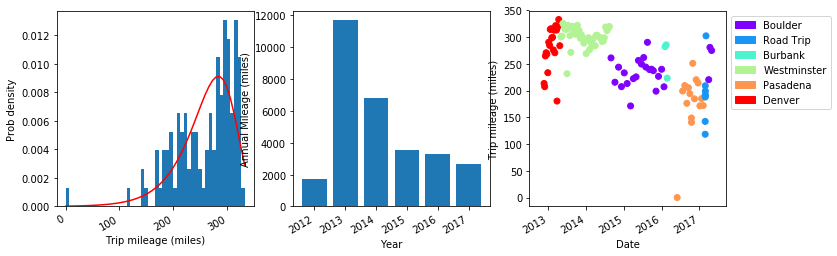

In [3]:
loc, scale = scipy.stats.gumbel_l.fit(tripMileage)
print "loc: %.1f, scale: %.1f" % (loc, scale)
print "0.95 interval: ", scipy.stats.gumbel_l.interval(0.95, loc, scale)
print "Quantiles: ", scipy.stats.mstats.mquantiles(tripMileage)
print "Maximum: ", numpy.max(tripMileage)

annualMileage = { dateBin : 0 for dateBin in dateBins }
for (fromDate, mileage) in zip(fromDates, tripMileage):
    annualMileage[fromDate.year] += mileage

f, axes = plot.subplots(1, 3)
f.autofmt_xdate()
f.set_size_inches(12, 4)

binValues, bins, patches = axes[0].hist(tripMileage, bins=50, normed=True)
Y = scipy.stats.gumbel_l.pdf(bins, loc, scale)
axes[0].plot(bins, Y, c='r')
axes[0].set_xlabel("Trip mileage (miles)")
axes[0].set_ylabel("Prob density")

axes[1].bar(dateBins, map(lambda x : annualMileage[x], dateBins))
axes[1].set_xlabel("Year")
axes[1].set_ylabel("Annual Mileage (miles)")
axes[1].set_xticks(dateBins)

axes[2].scatter(toDates, tripMileage, c = colors)
axes[2].set_xlabel("Date")
axes[2].set_ylabel("Trip mileage (miles)")
axes[2].legend(bbox_to_anchor=(1, 1), handles=destinationHandles)

plot.show()

# Refill
The assumption here is that the vehicle is driven until the tank is near empty and that the amount of gas purchased fills the tank completely (no partial refills.)

loc: 11.2, scale: 0.9
0.95 interval:  (7.738468694502961, 12.45257334512446)
Quantiles:  [ 10.4216  11.187   11.579 ]
Maximum:  12.274


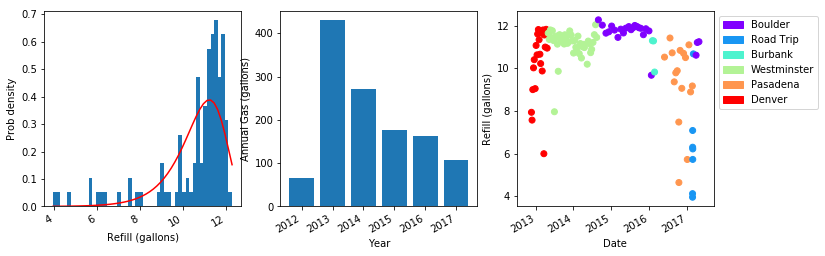

In [4]:
loc, scale = scipy.stats.gumbel_l.fit(gallons)
print "loc: %.1f, scale: %.1f" % (loc, scale)
print "0.95 interval: ", scipy.stats.gumbel_l.interval(0.95, loc, scale)
print "Quantiles: ", scipy.stats.mstats.mquantiles(gallons)
print "Maximum: ", numpy.max(gallons)

annualGallons = { dateBin : 0 for dateBin in dateBins }
for (fromDate, g) in zip(fromDates, gallons):
    annualGallons[fromDate.year] += g

f, axes = plot.subplots(1, 3)
f.autofmt_xdate()
f.set_size_inches(12, 4)

binValues, bins, patches = axes[0].hist(gallons, bins=50, normed=True)
Y = scipy.stats.gumbel_l.pdf(bins, loc, scale)
axes[0].plot(bins, Y, c='r')
axes[0].set_xlabel("Refill (gallons)")
axes[0].set_ylabel("Prob density")

axes[1].bar(dateBins, map(lambda x : annualGallons[x], dateBins))
axes[1].set_xlabel("Year")
axes[1].set_ylabel("Annual Gas (gallons)")
axes[1].set_xticks(dateBins)

axes[2].scatter(toDates, gallons, c = colors)
axes[2].set_xlabel("Date")
axes[2].set_ylabel("Refill (gallons)")
axes[2].legend(bbox_to_anchor=(1, 1), handles=destinationHandles)

plot.show()

# Trip Mileage and Tank Size correlation

Pearson R:  (0.53242593391926041, 9.1115447526556011e-10)


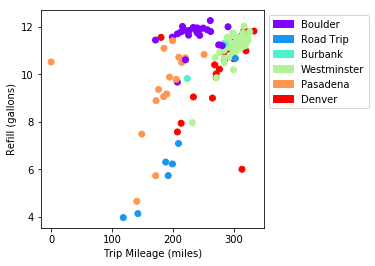

In [5]:
print "Pearson R: ", scipy.stats.pearsonr(tripMileage, gallons)

f, axes = plot.subplots(1, 1)
f.set_size_inches(4, 4)

axes.scatter(tripMileage, gallons, c = colors)
axes.set_xlabel("Trip Mileage (miles)")
axes.set_ylabel("Refill (gallons)")
axes.legend(bbox_to_anchor=(1, 1), handles=destinationHandles)

plot.show()

# Extended Amount
Cost to fill up the vehicle with gas each time

loc: 35.5, scale: 6.5
0.95 interval:  (11.480959323340205, 44.014151856750495)
Quantiles:  [ 25.78195    33.018239   38.5251794]
Maximum:  45.304039


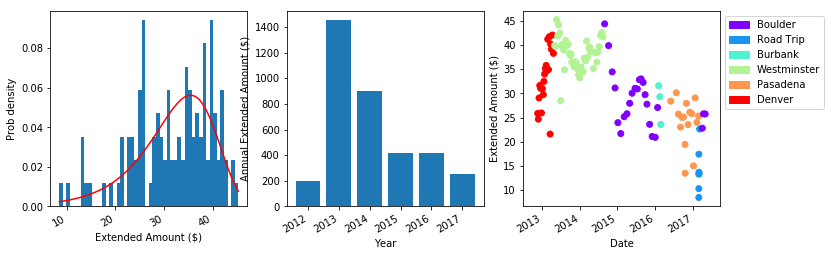

In [6]:
cost = numpy.array(map(lambda x : x["pricePerGallon"] * x["gallons"], data))

annualCost = { dateBin : 0 for dateBin in dateBins }
for (fromDate, c) in zip(fromDates, cost):
    annualCost[fromDate.year] += c
    
loc, scale = scipy.stats.gumbel_l.fit(cost)
print "loc: %.1f, scale: %.1f" % (loc, scale)
print "0.95 interval: ", scipy.stats.gumbel_l.interval(0.95, loc, scale)
print "Quantiles: ", scipy.stats.mstats.mquantiles(cost)
print "Maximum: ", numpy.max(cost)

f, axes = plot.subplots(1, 3)
f.autofmt_xdate()
f.set_size_inches(12, 4)

binValues, bins, patches = axes[0].hist(cost, bins=50, normed=True)
Y = scipy.stats.gumbel_l.pdf(bins, loc, scale)
axes[0].plot(bins, Y, c='r')
axes[0].set_xlabel("Extended Amount ($)")
axes[0].set_ylabel("Prob density")

axes[1].bar(dateBins, map(lambda x : annualCost[x], dateBins))
axes[1].set_xlabel("Year")
axes[1].set_ylabel("Annual Extended Amount ($)")
axes[1].set_xticks(dateBins)

axes[2].scatter(toDates, cost, c = colors)
axes[2].set_xlabel("Date")
axes[2].set_ylabel("Extended Amount ($)")
axes[2].legend(bbox_to_anchor=(1, 1), handles=destinationHandles)

plot.show()


# MPG
Average miles driven per gallon given a trip. Assumes bimodal distribution since there may be periods where city travel is more frequent than highway travel.

Quantiles:  [ 20.87544546  26.27169877  27.55553877]
Maximum:  52.1753625604
0.475632744041 [ 27.03433854] 1.11377436149
0.524367255959 [ 22.97506262] 43.6738691683


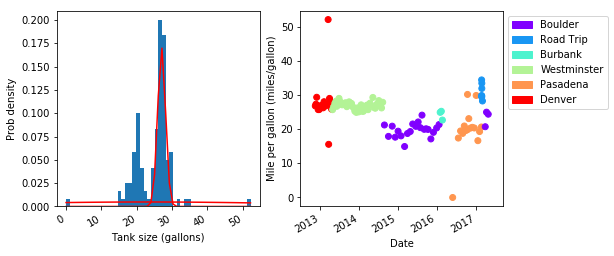

In [7]:
from sklearn.mixture import GaussianMixture

mpg = numpy.array(map(lambda x : x["tripMileage"] / x["gallons"], data))
print "Quantiles: ", scipy.stats.mstats.mquantiles(mpg)
print "Maximum: ", numpy.max(mpg)

gmm = GaussianMixture(n_components=2, covariance_type="spherical", n_init=20, init_params="random")
gmm.fit(mpg.reshape(-1,1))

f, axes = plot.subplots(1, 2)
f.autofmt_xdate()
f.set_size_inches(8, 4)

binValues, bins, patches = axes[0].hist(mpg, bins=50, normed=True)
axes[0].set_xlabel("Tank size (gallons)")
axes[0].set_ylabel("Prob density")

for pi, mu, sigma in zip(gmm.weights_, gmm.means_, gmm.covariances_):
    print pi, mu, sigma
    Y = pi * scipy.stats.norm.pdf(bins, mu[0], sigma)
    axes[0].plot(bins, Y, c='r')

axes[1].scatter(toDates, mpg, c = colors)
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Mile per gallon (miles/gallon)")
axes[1].legend(bbox_to_anchor=(1, 1), handles=destinationHandles)

plot.show()

# PPM
Only accounts for previous cost of gas added to tank- does not try to do any fifo or mixture accounting of previously added gas left in the tank 

loc: 0.121, scale: 0.023
0.95 interval:  (0.07677703289639147, 0.16616404357882669)
Quantiles:  [ 0.11375682  0.12442904  0.13006949]
Maximum:  0.23083103716


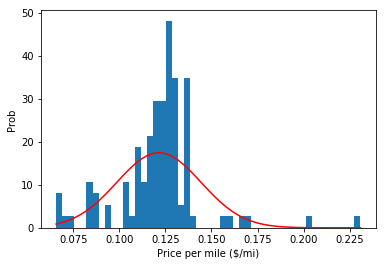

In [8]:
nonZeroMileage = filter(lambda x : x["tripMileage"] > 0, data)
costs = map(lambda (x, y) : x["pricePerGallon"] * y["gallons"], zip(nonZeroMileage, nonZeroMileage[1:]))
ppm = map(lambda (x, y) : y / x["tripMileage"], zip(nonZeroMileage[1:], costs))

loc, scale = scipy.stats.norm.fit(ppm)
print "loc: %.3f, scale: %.3f" % (loc, scale)
print "0.95 interval: ", scipy.stats.norm.interval(0.95, loc, scale)
print "Quantiles: ", scipy.stats.mstats.mquantiles(ppm)
print "Maximum: ", numpy.max(ppm)

binValues, bins, patches = plot.hist(ppm, bins=50, normed=True)
Y = scipy.stats.norm.pdf(bins, loc, scale)
plot.plot(bins, Y, c='r')
plot.xlabel("Price per mile ($/mi)")
plot.ylabel("Prob")
plot.show()

# Days between refills
TODO

loc: 10.0, scale: 6.6
0.95 interval:  (1.3696933219941965, 34.324807851732075)
Quantiles:  [  8.2  11.   16.8]
Maximum:  96.0


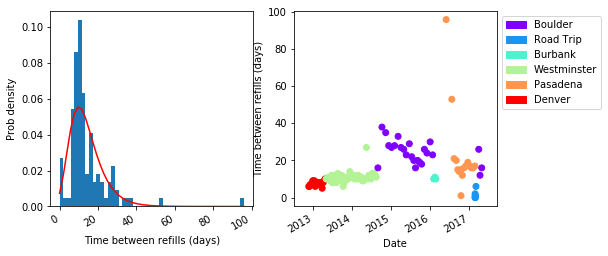

In [9]:
residuals = map(lambda x : x.total_seconds() / 60 / 60 / 24, (numpy.array(toDates) - numpy.array(fromDates)))

loc, scale = scipy.stats.gumbel_r.fit(residuals)
print "loc: %.1f, scale: %.1f" % (loc, scale)
print "0.95 interval: ", scipy.stats.gumbel_r.interval(0.95, loc, scale)
print "Quantiles: ", scipy.stats.mstats.mquantiles(residuals)
print "Maximum: ", numpy.max(residuals)

f, axes = plot.subplots(1, 2)
f.autofmt_xdate()
f.set_size_inches(8, 4)

binValues, bins, patches = axes[0].hist(residuals, bins=50, normed=True)
Y = scipy.stats.gumbel_r.pdf(bins, loc, scale)
axes[0].plot(bins, Y, c='r')
axes[0].set_xlabel("Time between refills (days)")
axes[0].set_ylabel("Prob density")

axes[1].scatter(toDates, residuals, c = colors)
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Time between refills (days)")
axes[1].legend(bbox_to_anchor=(1, 1), handles=destinationHandles)

plot.show()

# Timemap

Ref: http://ieeexplore.ieee.org/document/7363824

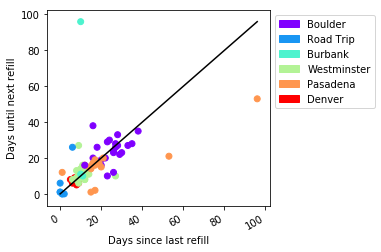

In [10]:
f, axes = plot.subplots(1, 1)
f.autofmt_xdate()
f.set_size_inches(4, 4)

maxX = numpy.max(residuals)

axes.plot([0,maxX],[0,maxX], c='black')
axes.scatter(residuals[:-1], residuals[1:], c = colors)
axes.set_xlabel("Days since last refill")
axes.set_ylabel("Days until next refill")
axes.legend(bbox_to_anchor=(1, 1), handles=destinationHandles)

plot.show()

# PPG
Goal: given the data on hand, can the future price per gallon at the pump be predicted accurately?
It is assumed that the same grade of gas was used throughout

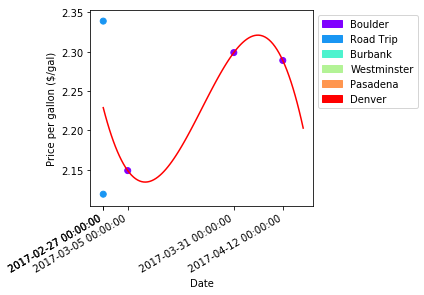

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

numPoints = 5
minDate = min(fromDates)

X = numpy.array(map(lambda x : (x - minDate).total_seconds() / 60 / 60 / 24, fromDates)).reshape(-1, 1)[-numPoints:]
Y = pricePerGallon[-numPoints:]

pf = PolynomialFeatures(numPoints)
model = LinearRegression()
model.fit(pf.fit_transform(X), Y)

forecastX = numpy.array(numpy.linspace(numpy.min(X), numpy.max(X) + 5, 100)).reshape(-1, 1)
forecastY = model.predict(pf.transform(forecastX))

f, axes = plot.subplots(1, 1)
f.autofmt_xdate()
f.set_size_inches(4, 4)

axes.plot(forecastX, forecastY, c='r')
axes.scatter(X, Y, c = colors[-numPoints:])
axes.set_xlabel("Date")
axes.set_ylabel("Price per gallon ($/gal)")
axes.legend(bbox_to_anchor=(1, 1), handles=destinationHandles)
axes.set_xticks(X)
axes.set_xticklabels(fromDates[-numPoints:])

plot.show()

# Destination frequency

In [ ]:
import collections

counts = dict(collections.Counter(destinations))

f, axes = plot.subplots(1, 1)
f.autofmt_xdate()
f.set_size_inches(4, 4)

axes.bar(counts.keys(), counts.values())
axes.set_xlabel("Destination")
axes.set_xticks(counts.keys())
axes.set_xticklabels(map(lambda x : nameFromDestId[x], counts.keys()))
axes.set_ylabel("Frequency")

plot.show()

# Destination prediction
Goal: Can the destination be computed from the available data?

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

minDate = min(fromDates)
dates = numpy.array(map(lambda x : (x - minDate).total_seconds() / 60 / 60 / 24, fromDates))

# time since prev event, time of event
features = numpy.column_stack((residuals, dates))
trainX, testX, trainY, testY = train_test_split(features, destinations, test_size=0.33)

model = GaussianNB()
model.fit(trainX, trainY)
predictY = model.predict(testX)

M = confusion_matrix(testY, predictY)
print "Confusion matrix:\n", M
print "Accuracy: %.2f" % accuracy_score(testY, predictY)

f, axes = plot.subplots(1, 3)
f.set_size_inches(12, 4)

axes[0].scatter(trainX[:,0], trainX[:,1], c = map(lambda x : colorFromDestId[x], trainY))
axes[0].set_xlabel("F0")
axes[0].set_ylabel("F1")
axes[0].set_title("Training")

axes[1].scatter(testX[:,0], testX[:,1], c = map(lambda x : colorFromDestId[x], predictY))
axes[1].set_xlabel("F0")
axes[1].set_ylabel("F1")
axes[1].set_title("Predicted")

axes[2].scatter(testX[:,0], testX[:,1], c = map(lambda x : colorFromDestId[x], testY))
axes[2].set_xlabel("F0")
axes[2].set_ylabel("F1")
axes[2].set_title("Actual")

axes[2].legend(bbox_to_anchor=(1, 1), handles=destinationHandles)

plot.show()